In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score
from scipy.stats import uniform

In [2]:
df = pd.read_csv("./kaggle - telco churn prediction.csv", dtype={"area code": str, "phone number": str})

In [3]:
df.dtypes

state                      object
account length              int64
area code                  object
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

In [13]:
target = "churn"
features = df.columns.tolist()
features.remove(target)
features.remove("area code")
features.remove("phone number")

In [14]:
df["churn"] = df["churn"].map({True: 1, False: 0})
df["international plan"] = df["international plan"].map({"yes": 1, "no": 0})
df["voice mail plan"] = df["voice mail plan"].map({"yes": 1, "no": 0})

In [15]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [16]:
states = pd.get_dummies(df["state"])

In [17]:
states.head()

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df = df.drop("state", axis=1)
df = pd.concat([states, df], axis=1)

features.remove("state")
features = features + states.columns.tolist()

In [22]:
feature_selector = SelectKBest(chi2, k=5)
feature_selector.fit(X=df.loc[:, features].values, y=df["churn"].values.ravel())

### Fit model They won't panda to train model, Just using Numpy array.
### .ravel change numpy array from 1 column to array vector for fit any model.

### define new Module, how to dir(.....) ex. dir(feature_selector)

SelectKBest(k=5, score_func=<function chi2 at 0x1a19c40830>)

In [23]:
feature_score = pd.DataFrame({"features": features, "score": feature_selector.scores_})
feature_score = feature_score.sort_values(by="score", ascending=False).reset_index(drop=True)

feature_score

,features,score
0,total day minutes,2314.169315
1,number vmail messages,620.628799
2,total day charge,393.399658
3,total eve minutes,367.164781
4,international plan,203.244178
...,...,...
63,UT,0.021097
64,OR,0.009520
65,GA,0.004557
66,DE,0.003396


In [28]:
df_selected_features = df.loc[:, feature_score["features"].tolist()[0:5] + ["customer service calls", "churn"]]

selected_features = df_selected_features.columns.tolist()
selected_features.remove(target)

x = df_selected_features.loc[:, selected_features].values
y = df_selected_features[target].values.ravel()

# Data Splitting
We will split X, y to be X_train, y_train, y_test

In [31]:
### stratify = y is keep volumn between True and False
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

# Modeling

## Logistic Regression

In [75]:
logreg = {}

logreg["hparams"] = {"C": uniform(loc=0, scale=4)}
logreg["model"] = LogisticRegression(solver = "lbfgs", max_iter=500, class_weight="balanced")
# logreg["model"] = LogisticRegression(solver = "lbfgs", max_iter=500)

# Random cross validation
logreg["rcv"] = RandomizedSearchCV(logreg["model"], logreg["hparams"], random_state = 0)
logreg["rsearch"] = logreg["rcv"].fit(X_train, y_train)

/Users/tanatjakphan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [76]:
logreg["rtuned_hparams"] = logreg["rsearch"].best_params_
logreg["rtuned_hparams"]

{'C': 2.860757465489678}

In [77]:
### Find value C in Dictionary
C = logreg["rtuned_hparams"]["C"]

### define new C with interval from (c * i / 10) in rang5 and range
logreg["gparams"] = {"C" : [C - (C*i/10) for i in range(5)] + [C + (C*i/10) for i in range(1, 5)]}
logreg["gcv"] = GridSearchCV(logreg["model"], logreg["gparams"])
logreg["gcv"].fit(X_train, y_train)
logreg["tuned_model"] = logreg["gcv"].best_estimator_

logreg["tuned_model"]

/Users/tanatjakphan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegression(C=2.860757465489678, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [78]:
print("Intercept : " + str(logreg["tuned_model"].intercept_[0]))
### intercept is logOdd, Baseline Odd

print("coefficients : " + str(logreg["tuned_model"].coef_[0]))
### coef [1] is if customer call more than now 1 minute logOdd plus 0.0127

Intercept : -4.726046458990549
coefficients : [ 0.01346233 -0.02186752 -0.00686785  0.00544209  2.37162917  0.56242144]


In [79]:
logreg["P(churn)"] = logreg["tuned_model"].predict_proba(X_test)[:, 1]
logreg["yhat"] = logreg["tuned_model"].predict(X_test)
logreg["cmat"] = confusion_matrix(y_test, logreg["yhat"], labels=[0, 1])
logreg["recall"] = recall_score(y_test, logreg["yhat"])
logreg["accuracy"] = accuracy_score(y_test, logreg["yhat"])
logreg["roc"] = roc_curve(y_test, logreg["P(churn)"], pos_label=1)
logreg["auc"] = round(roc_auc_score(y_test, logreg["P(churn)"]), 2)

In [80]:
recall_score(y_test, logreg["yhat"])

0.7731958762886598

## KNN

In [85]:
knn = {}
knn["hparams"] = {"n_neighbors": [(2*i + 1) for i in range(4)],
                 "metric": ["euclidean", "cosine", "manhattan", "chebyshev"],
                 "weights": ["distance", "uniform"]}
knn["model"] = KNeighborsClassifier()
knn["rcv"] = RandomizedSearchCV(knn["model"], knn["hparams"], random_state=0, cv=10)
knn["rsearch"] = knn["rcv"].fit(X_train, y_train)

In [87]:
knn["rtuned_hparams"] = knn["rsearch"].best_params_

knn["rtuned_hparams"]

{'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}

In [89]:
k = knn["rtuned_hparams"]["n_neighbors"]
metric = knn["rtuned_hparams"]["metric"]
weights = knn["rtuned_hparams"]["weights"]
knn["gparams"] = {"n_neighbors": [k -2, k, k +2], "metric": [metric], "weights": [weights]}
knn["gcv"] = GridSearchCV(knn["model"], knn["gparams"], cv=10)
knn["gcv"].fit(X_train, y_train)
knn["tuned_model"] = knn["gcv"].best_estimator_

In [91]:
knn["P(churn)"] = knn["tuned_model"].predict_proba(X_test)[:, 1]
knn["yhat"] = knn["tuned_model"].predict(X_test)
knn["cmat"] = confusion_matrix(y_test, knn["yhat"], labels=[0, 1])
knn["recall"] = recall_score(y_test, knn["yhat"])
knn["accuracy"] = accuracy_score(y_test, knn["yhat"])
knn["roc"] = roc_curve(y_test, knn["P(churn)"], pos_label=1)
knn["auc"] = round(roc_auc_score(y_test, knn["P(churn)"]), 2)

In [94]:
print(knn["recall"])
print(knn["accuracy"])

0.4020618556701031
0.9055472263868066


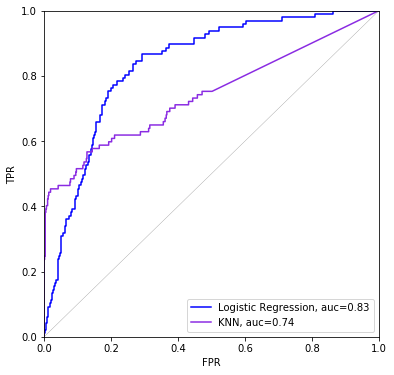

In [95]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(logreg["roc"][0], logreg["roc"][1], color="blue", label="Logistic Regression, auc="+str(logreg["auc"]))
ax.plot(knn["roc"][0], knn["roc"][1], color="blueviolet", label="KNN, auc="+str(knn["auc"]))
# ax.plot(rf["roc"][0], rf["roc"][1], color="tomato", label="Random Forest, auc="+str(rf["auc"]))
ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linewidth=0.3)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_xlim(left=0, right=1)
ax.set_ylim(bottom=0, top=1)
plt.legend(loc=4)
plt.show()
fig.savefig("roc.svg", format="svg")

In [96]:
print("Logistic Regression Recall: " + str(logreg["recall"]))
print("KNN Classification Recall: " + str(knn["recall"]))
# print("Random Forest Recall: " + str(rf["recall"]))

Logistic Regression Recall: 0.7731958762886598
KNN Classification Recall: 0.4020618556701031
